# Sistemas de recomendação com Python

Os sistemas de recomendação geralmente dependem de conjuntos de dados maiores e, especificamente, precisam ser organizados de forma particular. Devido a isso, não teremos um projeto para acompanhar este tópico, em vez disso, teremos um processo passo a passo mais intenso na criação de um sistema de recomendação com Python com o mesmo conjunto de dados de filme.

Dois tipos mais comuns de sistemas de recomendação são  baseados em ** conteúdo colaborativo e filtragem colaborativa (CF) **.

Devido ao auto grau de complexidade desses dois modelos concentraremos em fornecer um sistema de recomendação básico, sugerindo itens que são mais parecidos com um item específico, neste caso, filmes.

Tenha em mente que este não é um verdadeiro sistema de recomendação robusto, para descrevê-lo com mais precisão, apenas diz o que os filmes / itens são mais parecidos com a escolha do seu filme.



## Importar bibliotecas

In [21]:
import numpy as np
import pandas as pd


## Obter os dados

In [22]:
column_names = ['user_id', 'item_id', 'rating', 'timestamp']
df = pd.read_csv('u.data', sep='\t', names=column_names)

In [23]:
df.head()

,user_id,item_id,rating,timestamp
0,0,50,5,881250949
1,0,172,5,881250949
2,0,133,1,881250949
3,196,242,3,881250949
4,186,302,3,891717742


Agora vamos receber os títulos do filme:

In [24]:
movie_titles = pd.read_csv("Movie_Id_Titles")
movie_titles.head()

,item_id,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


Podemos juntá-los:

In [25]:
df = pd.merge(df,movie_titles,on='item_id')
df.head()

,user_id,item_id,rating,timestamp,title
0,0,50,5,881250949,Star Wars (1977)
1,290,50,5,880473582,Star Wars (1977)
2,79,50,4,891271545,Star Wars (1977)
3,2,50,5,888552084,Star Wars (1977)
4,8,50,5,879362124,Star Wars (1977)


# Análise exploratória de dados

Vamos explorar os dados um pouco e dê uma olhada em alguns dos filmes mais bem classificados.

## Visualização Importações

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
%matplotlib inline

Agurpamento com classificação média e número de avaliações dos 5 melhores avaliados

In [27]:
df.groupby('title')['rating'].mean().sort_values(ascending=False).head()

title
Marlene Dietrich: Shadow and Light (1996)     5.0
Prefontaine (1997)                            5.0
Santa with Muscles (1996)                     5.0
Star Kid (1997)                               5.0
Someone Else's America (1995)                 5.0
Name: rating, dtype: float64

Agrupamento com com número total de avaliações e os 5 filmes mais avaliados (mais vistos)

In [28]:
df.groupby('title')['rating'].count().sort_values(ascending=False).head()

title
Star Wars (1977)             584
Contact (1997)               509
Fargo (1996)                 508
Return of the Jedi (1983)    507
Liar Liar (1997)             485
Name: rating, dtype: int64

Vamos criar um dataframes dos filmes agrupando por titulo pegando somente a média das avaliações

In [29]:
ratings = pd.DataFrame(df.groupby('title')['rating'].mean())
ratings.head()

,rating
title,
'Til There Was You (1997),2.333333
1-900 (1994),2.600000
101 Dalmatians (1996),2.908257
12 Angry Men (1957),4.344000
187 (1997),3.024390


Agora criamos mais uma coluna com as contagem de avaliações para cada filme:

In [30]:
ratings['num of ratings'] = pd.DataFrame(df.groupby('title')['rating'].count())
ratings.head()


,rating,num of ratings
title,,
'Til There Was You (1997),2.333333,9
1-900 (1994),2.600000,5
101 Dalmatians (1996),2.908257,109
12 Angry Men (1957),4.344000,125
187 (1997),3.024390,41


Total de linhas do dataframe

In [31]:
ratings.shape

(1664, 2)

histogramas:

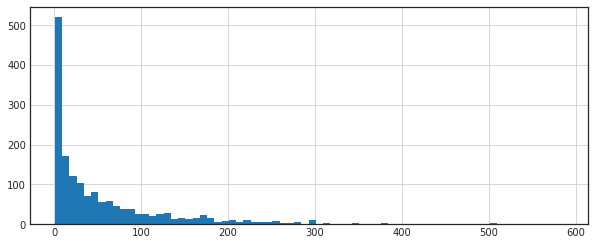

In [32]:
plt.figure(figsize=(10,4))
ratings['num of ratings'].hist(bins=70)

Ao analizar o grafico, notamos uma grande predominancia de filmes que foram vistos apenas por um usuario

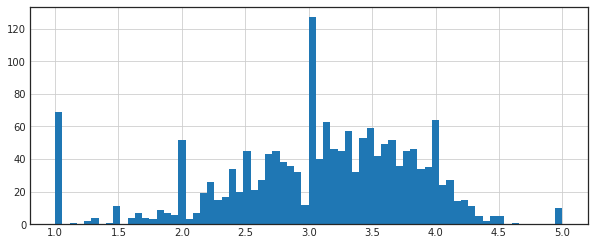

In [33]:
plt.figure(figsize=(10,4))
ratings['rating'].hist(bins=70)

Distribuição dos filmes por pontuação, tirando os picos que possivelmente são filmes vistos apenas uma vez, temos uma distribuição normal.

/home/jairo/.local/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


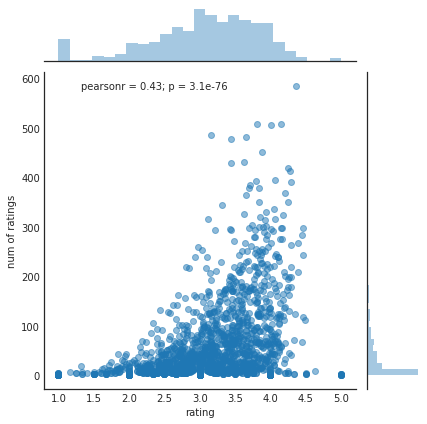

In [34]:
sns.jointplot(x='rating',y='num of ratings',data=ratings,alpha=0.5)

Cruzando as informações de média e quantidade de avaliações, notamos um aumento na contagem das avaliações conforme o total de avaliações cresce, ou seja, os filmes mais vistos, geramente são os mais bem avaliados.

# Modelo de Recomendação Baseado em items

Agora criamos uma matriz que tenha o ID dos usuários em um acesso e o título do filme em outro eixo. Cada célula irá consistir na classificação que o usuário deu a esse filme. Observe que haverá muitos valores de NaN, porque a maioria das pessoas não viu a maioria dos filmes.

In [35]:
moviemat = df.pivot_table(index='user_id',columns='title',values='rating')
moviemat.head()

title,'Til There Was You (1997),1-900 (1994),101 Dalmatians (1996),12 Angry Men (1957),187 (1997),2 Days in the Valley (1996),"20,000 Leagues Under the Sea (1954)",2001: A Space Odyssey (1968),3 Ninjas: High Noon At Mega Mountain (1998),"39 Steps, The (1935)",...,Yankee Zulu (1994),Year of the Horse (1997),You So Crazy (1994),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),"Young Poisoner's Handbook, The (1995)",Zeus and Roxanne (1997),unknown,Á köldum klaka (Cold Fever) (1994)
user_id,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,2.0,5.0,NaN,NaN,3.0,4.0,NaN,NaN,...,NaN,NaN,NaN,5.0,3.0,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Criamos um dataframe novo com os dados em uma outra dimenção a fim de buscar a correlação da avaliação de cada usuário com 
cada filme. Os dados com NaN são filmes que não foram avaliados pelo usuario

Filme mais avaliado:

In [36]:
ratings.sort_values('num of ratings',ascending=False).head(10)

,rating,num of ratings
title,,
Star Wars (1977),4.359589,584
Contact (1997),3.803536,509
Fargo (1996),4.155512,508
Return of the Jedi (1983),4.007890,507
Liar Liar (1997),3.156701,485
"English Patient, The (1996)",3.656965,481
Scream (1996),3.441423,478
Toy Story (1995),3.878319,452
Air Force One (1997),3.631090,431


Vamos escolher dois filmes: starwars, um filme de ficção científica e Liar Liar, uma comédia.

In [37]:
ratings.head()

,rating,num of ratings
title,,
'Til There Was You (1997),2.333333,9
1-900 (1994),2.600000,5
101 Dalmatians (1996),2.908257,109
12 Angry Men (1957),4.344000,125
187 (1997),3.024390,41


Agora vamos pegar as avaliações dos usuários para esses dois filmes:

In [38]:
starwars_user_ratings = moviemat['Star Wars (1977)']
liarliar_user_ratings = moviemat['Liar Liar (1997)']
starwars_user_ratings.head()

user_id
0    5.0
1    5.0
2    5.0
3    NaN
4    5.0
Name: Star Wars (1977), dtype: float64

Podemos então usar o método corrwith() para obter correlações entre duas séries:

In [39]:
similar_to_starwars = moviemat.corrwith(starwars_user_ratings)
similar_to_liarliar = moviemat.corrwith(liarliar_user_ratings)

/home/jairo/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:3175: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/home/jairo/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)


Buscamos filmes que são similares analizando a correlação entre as avaliações de starwars e lielie usando o método corrwith. Com ele encontramos a similaridade de notas dadas por pessoas que assistiram os filmes mostrados a cima e starwars

Vamos limpar isso removendo valores de NaN e usando um DataFrame em vez de uma série:

In [40]:
corr_starwars = pd.DataFrame(similar_to_starwars,columns=['Correlation'])
corr_starwars.dropna(inplace=True)
corr_starwars.head()

,Correlation
title,
'Til There Was You (1997),0.872872
1-900 (1994),-0.645497
101 Dalmatians (1996),0.211132
12 Angry Men (1957),0.184289
187 (1997),0.027398


Agora, se classificarmos o quadro de dados por correlação, devemos obter os filmes mais parecidos, no entanto, notemos que obtemos alguns resultados que realmente não fazem sentido. Isso ocorre porque há muitos filmes apenas assistidos uma vez por usuários que também assistiram a star wars (foi o filme mais popular).

In [41]:
corr_starwars.sort_values('Correlation',ascending=False).head(10)

,Correlation
title,
Hollow Reed (1996),1.0
Commandments (1997),1.0
Cosi (1996),1.0
No Escape (1994),1.0
Stripes (1981),1.0
Star Wars (1977),1.0
Man of the Year (1995),1.0
"Beans of Egypt, Maine, The (1994)",1.0
"Old Lady Who Walked in the Sea, The (Vieille qui marchait dans la mer, La) (1991)",1.0


Vamos corrigir isso, filtrando filmes com menos de 100 comentários (esse valor foi escolhido com base no histograma anterior).

In [42]:
corr_starwars = corr_starwars.join(ratings['num of ratings'])
corr_starwars.head()

,Correlation,num of ratings
title,,
'Til There Was You (1997),0.872872,9
1-900 (1994),-0.645497,5
101 Dalmatians (1996),0.211132,109
12 Angry Men (1957),0.184289,125
187 (1997),0.027398,41


Agora, classifique os valores e observe como os títulos têm muito mais sentido: 
Pegamos a contagem das correlações for maior que 100 ordenando pelas correlaçoes em ordem decrescente

In [43]:
corr_starwars[corr_starwars['num of ratings']>100].sort_values('Correlation',ascending=False).head()

,Correlation,num of ratings
title,,
Star Wars (1977),1.000000,584
"Empire Strikes Back, The (1980)",0.748353,368
Return of the Jedi (1983),0.672556,507
Raiders of the Lost Ark (1981),0.536117,420
Austin Powers: International Man of Mystery (1997),0.377433,130


Apartir do histograma, percebemos que o filtro é interessante apartir de 100 avaliações:

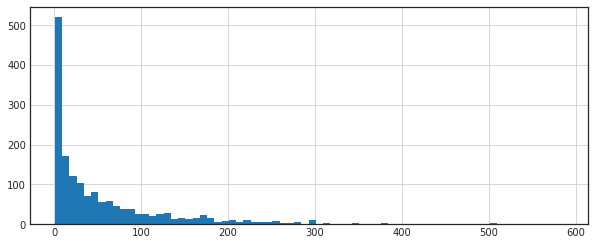

In [44]:
plt.figure(figsize=(10,4))
ratings['num of ratings'].hist(bins=70)

Agora o mesmo para Liar Liar:

In [45]:
corr_liarliar = pd.DataFrame(similar_to_liarliar,columns=['Correlation'])
corr_liarliar.dropna(inplace=True)
corr_liarliar = corr_liarliar.join(ratings['num of ratings'])
corr_liarliar[corr_liarliar['num of ratings']>100].sort_values('Correlation',ascending=False).head()

,Correlation,num of ratings
title,,
Liar Liar (1997),1.000000,485
Batman Forever (1995),0.516968,114
"Mask, The (1994)",0.484650,129
Down Periscope (1996),0.472681,101
Con Air (1997),0.469828,137


In [48]:
corr_liarliar.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1375 entries, 'Til There Was You (1997) to unknown
Data columns (total 2 columns):
Correlation       1375 non-null float64
num of ratings    1375 non-null int64
dtypes: float64(1), int64(1)
memory usage: 72.2+ KB


# Modelo de Recomendação Usando KNN


Padronize as variáveis

In [50]:
from sklearn.preprocessing import StandardScaler

** Criamos um objeto StandardScaler() chamado scaler. **

In [51]:
scaler = StandardScaler()

** Usamos o método fit() do objeto para treinar o modelo. **

In [52]:
df.head()

,user_id,item_id,rating,timestamp,title
0,0,50,5,881250949,Star Wars (1977)
1,290,50,5,880473582,Star Wars (1977)
2,79,50,4,891271545,Star Wars (1977)
3,2,50,5,888552084,Star Wars (1977)
4,8,50,5,879362124,Star Wars (1977)


In [53]:
scaler.fit(df.drop('title',axis=1))

StandardScaler(copy=True, with_mean=True, with_std=True)

** Usamos o método .transform () para transformar os parâmetros em uma versão padronizada. **

In [54]:
scaled_features = scaler.transform(df.drop('title',axis=1))

** Convertemos os parâmetros padronizados em um DataFrame e verifique o cabeçalho desse DataFrame para garantir que a transform() funcionou. **

In [55]:
df_feat = pd.DataFrame(scaled_features,columns=df.columns[:-1])
df_feat.head()

,user_id,item_id,rating,timestamp
0,-1.734562,-1.135203,1.305976,-0.426260
1,-0.646876,-1.135203,1.305976,-0.571732
2,-1.438261,-1.135203,0.417639,1.448934
3,-1.727061,-1.135203,1.305976,0.940030
4,-1.704557,-1.135203,1.305976,-0.779724


In [60]:
df_feat.drop('timestamp',axis=1).head()

,user_id,item_id,rating
0,-1.734562,-1.135203,1.305976
1,-0.646876,-1.135203,1.305976
2,-1.438261,-1.135203,0.417639
3,-1.727061,-1.135203,1.305976
4,-1.704557,-1.135203,1.305976


# Divisão treino-teste

** Usamos o método train_test_split para dividir seus dados em um conjunto treino e teste.**

In [62]:
from sklearn.model_selection import train_test_split

In [63]:
X_train, X_test, y_train, y_test = train_test_split(scaled_features,df['title'],
                                                    test_size=0.30)

** Importamos o KNeighborClassifier do scikit learn. **

In [64]:
from sklearn.neighbors import KNeighborsClassifier

** Criamos uma instância do modelo KNN com n_neighbors = 1 **

In [66]:
knn = KNeighborsClassifier(n_neighbors=1)

** Ajustamos este modelo KNN aos dados de treinamento. **

In [67]:
knn.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')

# Previsões e avaliações
Vamos avaliar o nosso modelo KNN!

** Usamos o método de previsão para prever valores usando seu modelo KNN e X_test. **

In [69]:
pred = knn.predict(X_test)

** Criamos uma matriz de confusão e um relatório de classificação. **

In [70]:
from sklearn.metrics import classification_report,confusion_matrix

# Escolhendo o valor K
Usamos o método do cotovelo para escolher um bom valor K!

** Criamos um loop for que treina vários modelos KNN com valores k diferentes e, em seguida, mantenha um registro do error_rate para cada um desses modelos com uma lista. Consulte o notebook se você estiver confuso nesta etapa. **

In [73]:
error_rate = []

# Will take some time
for i in range(1,40):
    
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))

** Agora criamos o seguinte gráfico usando as informações do seu loop. **

Text(0,0.5,'Error Rate')

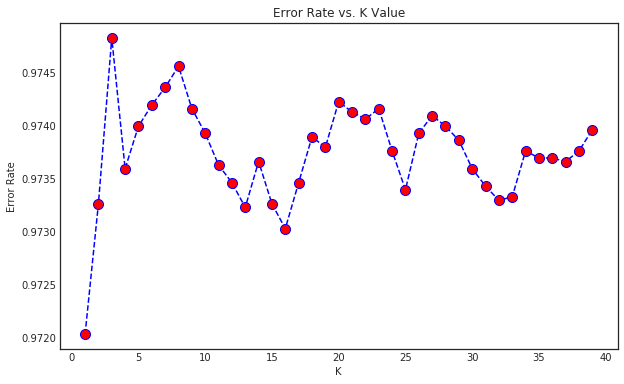

In [74]:
plt.figure(figsize=(10,6))
plt.plot(range(1,40),error_rate,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

## Treine seu modelo novamente com novo valor K

** Treinamos novamente seu modelo com o melhor valor K (até você para decidir o que deseja) e re-faça o relatório de classificação e a matriz de confusão. **

In [87]:
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix

In [99]:
df.head()

,user_id,item_id,rating,timestamp,title
0,0,50,5,881250949,Star Wars (1977)
1,290,50,5,880473582,Star Wars (1977)
2,79,50,4,891271545,Star Wars (1977)
3,2,50,5,888552084,Star Wars (1977)
4,8,50,5,879362124,Star Wars (1977)


In [105]:
test = df.drop_duplicates(['user_id','title'])
df_pivot = test.pivot(index='title',columns='user_id',values='rating').fillna(0)
df_matrix = csr_matrix(df_pivot.values)

### Para utilizar o algoritmo através da biblioteca Sklearn KNN temos que criar uma matrix com o dataframe e apartir do filme pivot o algoritmo fornece o filme mais proximo dele

In [106]:
modelo_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
modelo_knn.fit(df_matrix)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
         metric_params=None, n_jobs=1, n_neighbors=5, p=2, radius=1.0)

In [121]:
query_index = np.random.choice(df_pivot.shape[0])
distances, indices = modelo_knn.kneighbors(df_pivot.iloc[query_index, :].reshape(1, -1), n_neighbors = 2)

for i in range(0, len(distances.flatten())):
    if i == 0:
        print('Recomencação para {0}:\n'.format(df_pivot.index[query_index]))
    else:
        print('{0}: {1}, com distancia de {2}'.format(i, df_pivot.index[indices.flatten()[i]], distances.flatten()[i]))


Recomencação para Con Air (1997):

1: Face/Off (1997), com distancia de 0.4467303769717892


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  
